In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [3]:
# loading the data
data_dir = 'lung_colon_image_set/lung_image_sets'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths               labels
0      lung_colon_image_set/lung_image_sets\lung_aca\...  Lung_adenocarcinoma
1      lung_colon_image_set/lung_image_sets\lung_aca\...  Lung_adenocarcinoma
2      lung_colon_image_set/lung_image_sets\lung_aca\...  Lung_adenocarcinoma
3      lung_colon_image_set/lung_image_sets\lung_aca\...  Lung_adenocarcinoma
4      lung_colon_image_set/lung_image_sets\lung_aca\...  Lung_adenocarcinoma
...                                                  ...                  ...
15004  lung_colon_image_set/lung_image_sets\train\lung_n                train
15005  lung_colon_image_set/lung_image_sets\train\lun...                train
15006  lung_colon_image_set/lung_image_sets\val\lung_aca                  val
15007    lung_colon_image_set/lung_image_sets\val\lung_n                  val
15008  lung_colon_image_set/lung_image_sets\val\lung_scc                  val

[15009 rows x 2 columns]

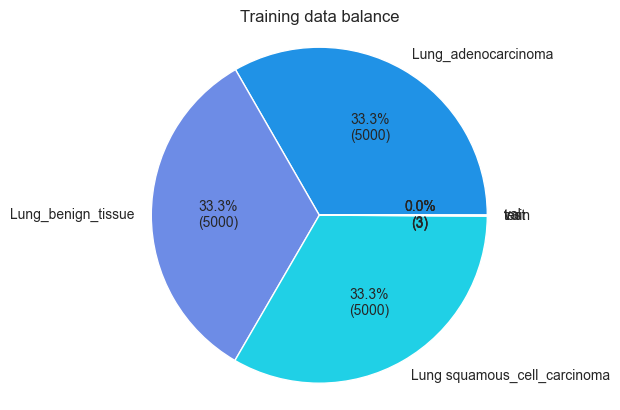

In [4]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [5]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [6]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


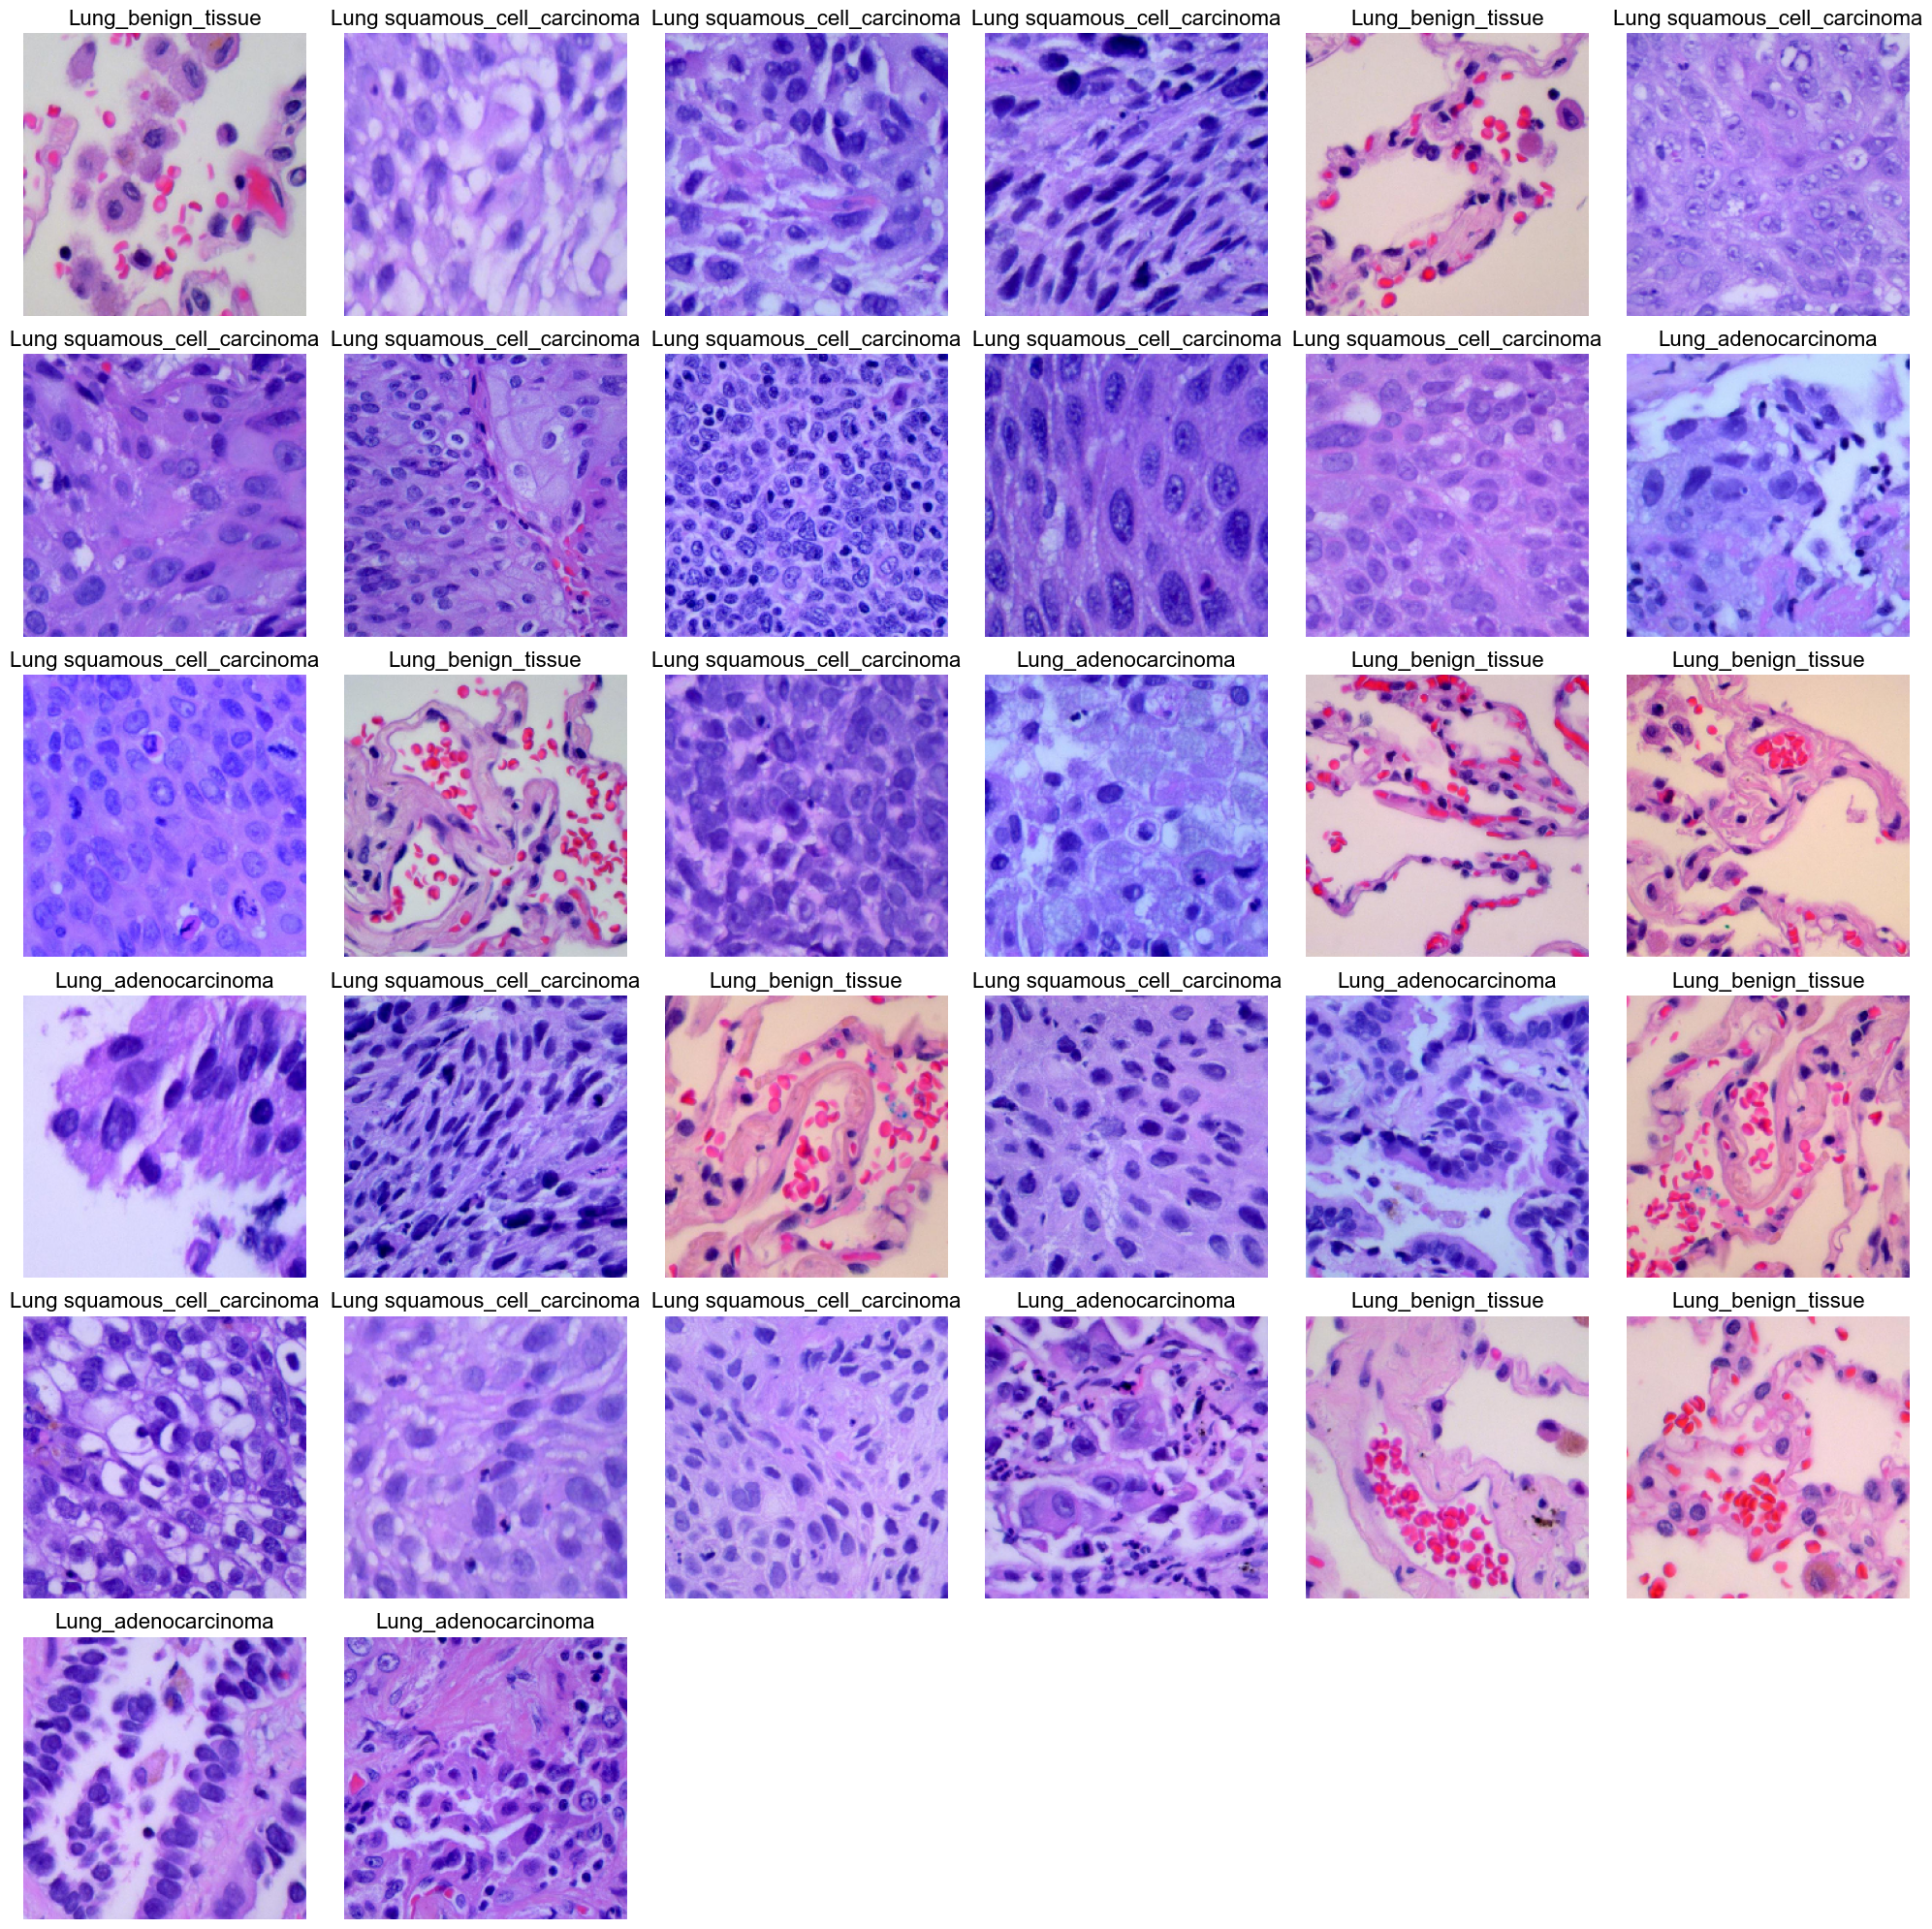

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [9]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [10]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [11]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 56, 56, 32)        14016     
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 64)        55680     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       2

In [19]:
# train the model
epochs = 20   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

# Guardar el modelo entrenado
cnn_model.save('modelo_cnn_mejor_cancer_pulmon.h5')
print("Modelo guardado como 'modelo_cnn_mejor_cancer_pulmon.h5'")

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 140s 374ms/step - accuracy: 0.8941 - loss: 0.2953 - val_accuracy: 0.9113 - val_loss: 0.2665
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 144s 385ms/step - accuracy: 0.9319 - loss: 0.1885 - val_accuracy: 0.9660 - val_loss: 0.0896
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 147s 390ms/step - accuracy: 0.9469 - loss: 0.1457 - val_accuracy: 0.9507 - val_loss: 0.1263
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 146s 389ms/step - accuracy: 0.9534 - loss: 0.1347 - val_accuracy: 0.9093 - val_loss: 0.2450
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 145s 388ms/step - accuracy: 0.9519 - loss: 0.1318 - val_accuracy: 0.9607 - val_loss: 0.1108
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 381ms/step - accuracy: 0.9620 - loss: 0.0999 - val_accuracy: 0.8947 - val_loss: 0.2758
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 138s 367ms/step - accuracy: 0.9666 - loss: 0.1009 - val_accuracy: 0.9367 - val_loss: 0.1800
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 376ms/step - accuracy: 0.9692 -

Modelo guardado como 'modelo_cnn_mejor_cancer_pulmon.h5'


In [12]:
# Display model performance
model_performance(history, epochs)

NameError: name 'history' is not defined

In [21]:
# Model evaluation
model_evaluation(cnn_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.9992 - loss: 0.0035
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9906 - loss: 0.0192
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9922 - loss: 0.0337
Train Loss:  0.004110901150852442
Train Accuracy:  0.9986666440963745
--------------------
Validation Loss:  0.025751568377017975
Validation Accuracy:  0.9893333315849304
--------------------
Test Loss:  0.03065405786037445
Test Accuracy:  0.9919999837875366


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step


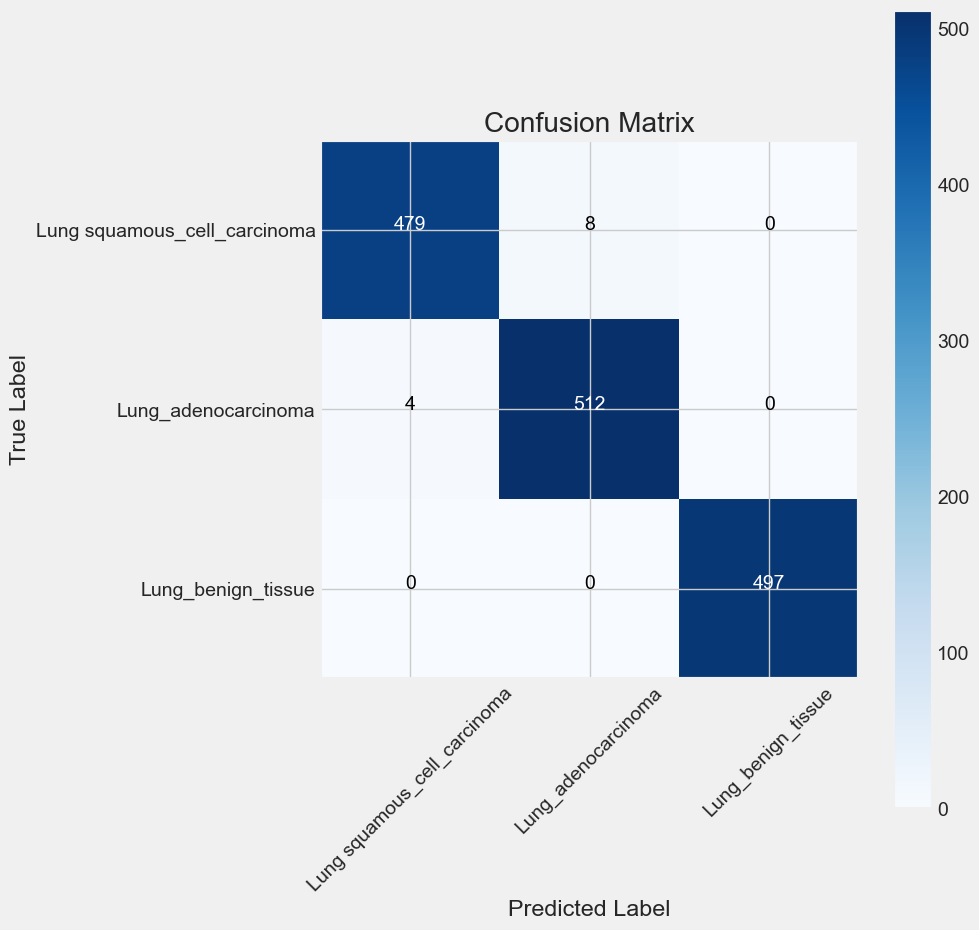

In [22]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

In [13]:
# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

In [14]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [15]:
# train the model
epochs = 20   # number of all epochs in training

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)
EfficientNetB3_model.save('modelo_netb3.h5')
print("Modelo guardado como 'modelo_netb3.h5'")

Epoch 1/20


375/375 [==============================] - 698s 2s/step - loss: 0.5116 - accuracy: 0.7972 - val_loss: 1.4379 - val_accuracy: 0.3553
Epoch 2/20
375/375 [==============================] - 648s 2s/step - loss: 0.2312 - accuracy: 0.9207 - val_loss: 0.1765 - val_accuracy: 0.9473
Epoch 3/20
375/375 [==============================] - 650s 2s/step - loss: 0.1639 - accuracy: 0.9492 - val_loss: 0.0742 - val_accuracy: 0.9827
Epoch 4/20
345/375 [==========================>...] - ETA: 50s - loss: 0.1204 - accuracy: 0.9659

KeyboardInterrupt: 

In [ ]:
# Display model performance
model_performance(EfficientNetB3_history, epochs)

In [ ]:
# Model evaluation
model_evaluation(EfficientNetB3_model)

In [ ]:
# get predictions
y_pred = get_pred(EfficientNetB3_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)